#### Start with installing the snowflake connector

In [1]:
!pip install snowflake-connector-python[pandas]

     |████████████████████████████████| 13.2 MB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 63.1 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 69.2 MB/s eta 0:00:01
     |████████████████████████████████| 192 kB 82.5 MB/s eta 0:00:01
     |████████████████████████████████| 20.7 MB 20.5 MB/s eta 0:00:01   |                                | 71 kB 30.3 MB/s eta 0:00:01     |██████████████████▌             | 12.0 MB 20.5 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 5.8 MB/s  eta 0:00:01
     |████████████████████████████████| 136 kB 82.2 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 878 kB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 83.5 MB/s eta 0:00:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 4.0.0
    Uninstalling pyarrow-4.0.0:
      Successfully uninstalled pyarrow-4.0.0


##### Import Packages Needed

In [2]:
import pandas as pd
from snowflake.connector import pandas_tools as sfpd
import snowflake.connector
import toml
import numpy as np
import datetime as dt

Connect to the Environment

In [3]:
env = toml.load('config.toml')
conn = snowflake.connector.connect(
                user= env['trial'].get('user'),
                password= env['trial'].get('password'),
                account= env['trial'].get('account'),
                warehouse=env['trial'].get('warehouse'),
                database=env['trial'].get('database'),
                schema=env['trial'].get('schema')
                )

In [4]:
cur = conn.cursor()
sql = "select * from abalone_test;"
cur.execute(sql)
abalone_test = cur.fetch_pandas_all()

In [5]:
tbl = 'ABALONE_OBSDATES'
sql = f"drop table if exists {tbl};"
cur.execute(sql);

In [6]:
abalone_test.head()

,SEX,LENGTH,DIAMETER,HEIGHT,WHOLE_WEIGHT,SHUCKED_WEIGHT,VISCERA_WEIGHT,SHELL_WEIGHT,RINGS
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
# the limit ensures that rest of the logic is edge-case safe.
sql=f'''select distinct postal_code from 
        "WEATHERSOURCE_PARTNER_WEATHER_SOURCE_SAMPLE_DAILY_CAPITALS_CA_EU_US"."PUBLIC"."HISTORY_DAY"
        where date_valid_std = current_date()-7
        limit {len(abalone_test)}; '''

In [8]:
cur.execute(sql)
postal_codes = cur.fetch_pandas_all()

In [9]:
abalone_test['POSTAL_CODE'] = [postal_codes.sample(1)['POSTAL_CODE'].item() 
                               for i in range(0, len(abalone_test))]

In [10]:
abalone_test.POSTAL_CODE.describe() #check if it works out ok!

count      4177
unique       64
top       36101
freq         96
Name: POSTAL_CODE, dtype: object

In [11]:
abalone_test['OBS_DATE']=dt.date.today() - dt.timedelta(7) # get today and go back 7 days

In [12]:
abalone_test.head()

,SEX,LENGTH,DIAMETER,HEIGHT,WHOLE_WEIGHT,SHUCKED_WEIGHT,VISCERA_WEIGHT,SHELL_WEIGHT,RINGS,POSTAL_CODE,OBS_DATE
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,48226,2021-05-12
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,N8S,2021-05-12
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,94203,2021-05-12
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,G1R,2021-05-12
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,12201,2021-05-12


In [13]:
abalone_test.describe()

,LENGTH,DIAMETER,HEIGHT,WHOLE_WEIGHT,SHUCKED_WEIGHT,VISCERA_WEIGHT,SHELL_WEIGHT,RINGS
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [14]:
sql = f"create table {tbl} like ABALONE_TEST;"
cur.execute(sql);

In [15]:
sql = f"alter table {tbl}  add column POSTAL_CODE varchar(16), column OBS_DATE date;"
cur.execute(sql);

In [16]:
try:
    success, nchunks, nrows, _ = sfpd.write_pandas(conn, abalone_test,tbl)
    print(f"INFO: Write Pandas method reported Success = {success}, with a total number of {nrows} rows written to the table {tbl}")
except RunTimeError as e:
    print(e) 

INFO: Write Pandas method reported Success = True, with a total number of 4177 rows written to the table ABALONE_OBSDATES


In [17]:
join_sql = '''select OBS_DATE, a.POSTAL_CODE, SEX, LENGTH, DIAMETER, HEIGHT,
        WHOLE_WEIGHT, SHUCKED_WEIGHT,VISCERA_WEIGHT, SHELL_WEIGHT, RINGS, 
        MIN_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_AIR_2M_F,MAX_TEMPERATURE_AIR_2M_F,
        MIN_HUMIDITY_RELATIVE_2M_PCT,AVG_HUMIDITY_RELATIVE_2M_PCT,MAX_HUMIDITY_RELATIVE_2M_PCT
        from "SGDB"."PUBLIC"."ABALONE_OBSDATES" as a
        inner join "WEATHERSOURCE_PARTNER_WEATHER_SOURCE_SAMPLE_DAILY_CAPITALS_CA_EU_US"."PUBLIC"."HISTORY_DAY" as b on b.date_valid_std = a.obs_date
        and a.POSTAL_CODE = b. POSTAL_CODE;'''
cur.execute(join_sql)
ab_temp_humidity_df = cur.fetch_pandas_all()

In [18]:
ab_temp_humidity_df.head()

,OBS_DATE,POSTAL_CODE,SEX,LENGTH,DIAMETER,HEIGHT,WHOLE_WEIGHT,SHUCKED_WEIGHT,VISCERA_WEIGHT,SHELL_WEIGHT,RINGS,MIN_TEMPERATURE_AIR_2M_F,AVG_TEMPERATURE_AIR_2M_F,MAX_TEMPERATURE_AIR_2M_F,MIN_HUMIDITY_RELATIVE_2M_PCT,AVG_HUMIDITY_RELATIVE_2M_PCT,MAX_HUMIDITY_RELATIVE_2M_PCT
0,2021-05-12,A1C,M,0.56,0.450,0.185,1.070,0.3805,0.1750,0.410,19,38.6,41.0,45.3,69,86,97
1,2021-05-12,A1C,F,0.46,0.380,0.130,0.639,0.3000,0.1525,0.160,11,38.6,41.0,45.3,69,86,97
2,2021-05-12,A1C,F,0.47,0.360,0.130,0.472,0.1820,0.1140,0.150,10,38.6,41.0,45.3,69,86,97
3,2021-05-12,A1C,M,0.59,0.450,0.185,1.283,0.4730,0.2760,0.425,16,38.6,41.0,45.3,69,86,97
4,2021-05-12,A1C,M,0.58,0.455,0.170,0.930,0.4080,0.2590,0.220,9,38.6,41.0,45.3,69,86,97


,count,mean,std,min,5%,10%,25%,50%,75%,90%,100%,max
AVG_HUMIDITY_RELATIVE_2M_PCT,4177.0,57.178118,17.932207,14.0,23.0,40.0,47.0,54.0,67.0,87.0,92.0,92.0
MAX_HUMIDITY_RELATIVE_2M_PCT,4177.0,80.429734,15.721944,24.0,39.0,62.0,73.0,82.0,94.0,97.0,100.0,100.0


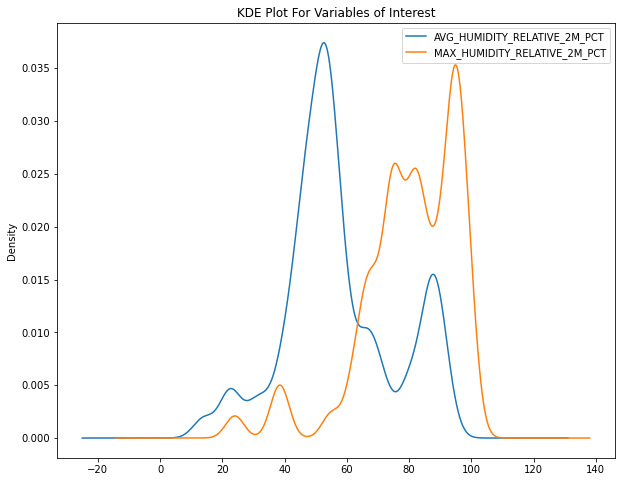

In [31]:
interest_vars = ['AVG_HUMIDITY_RELATIVE_2M_PCT','MAX_HUMIDITY_RELATIVE_2M_PCT']
ab_temp_humidity_df[interest_vars].plot(kind='kde',figsize=(10,8), title='KDE Plot For Variables of Interest');
pd.DataFrame(ab_temp_humidity_df[interest_vars].describe(percentiles=[.05,.10,.25,.5,.75,.9,1.])).T

In [32]:
cur.close()
conn.close()